In [1]:
import tensorflow as tf

print(tf.__version__)

2.0.0


In [2]:
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
inputs = keras.Input(shape=(128, 128, 3), name='img')

x = layers.Conv2D(
    filters=64,             # 卷积层神经元（卷积核）数目
    kernel_size=9,          # 感受野大小
    padding='same',         # padding策略（vaild 或 same）
    activation=tf.nn.relu   # 激活函数
)(inputs)

x = layers.Conv2D(
    filters=32,      
    kernel_size=1,
    padding='same',  
    activation=tf.nn.relu
)(x)

outputs = layers.Conv2D(
    filters=1,
    kernel_size=5,          
    padding='same'          # 不设置激活函数
)(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='SRCNN_model')# 通过在图层图中指定其输入和输出来创建一个model
  
model.summary() # 查看模型摘要，需要模型built（实例化）后调用

Model: "SRCNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      15616     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      2080      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 3)       2403      
Total params: 20,099
Trainable params: 20,099
Non-trainable params: 0
_________________________________________________________________


In [7]:
import cv2 as cv
import numpy as np

ishape = 128

# load data
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

train_images = train_images / 255.                               #(50000, 32, 32, 3)
test_images  = test_images  / 255.                               #(10000, 32, 32, 3)

'''
CIFAR10 had't 128*128*3 images use bicubic alternatived,and bicubic use nearest alternatived.
X_: image applied bicubic interpolation (low-resolution),(50000, 128, 128, 3)
y_: image with original resolution (high-resolution),(10000, 128, 128, 3)
'''
X_train = np.array([cv.resize(i,(ishape,ishape), interpolation=cv.INTER_NEAREST) for i in train_images])
X_test  = np.array([cv.resize(i,(ishape,ishape), interpolation=cv.INTER_NEAREST) for i in test_images])
y_train = np.array([cv.resize(i,(ishape,ishape), interpolation=cv.INTER_CUBIC) for i in train_images])
y_test  = np.array([cv.resize(i,(ishape,ishape), interpolation=cv.INTER_CUBIC) for i in test_images]) 

In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss='mse',       
              metrics=['mae'])    # 编译

history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=3,
                    validation_split=0.2)# 训练

test_scores = model.evaluate(X_test, y_test, verbose=2) # 评估

print('Test loss:', test_scores[0])
print('Test mae:', test_scores[1])

# Save entire model to a HDF5 file
model.save('SRCNN.h5')

Train on 40000 samples, validate on 10000 samples
40000/40000 [==============================] - 2381s 60ms/sample - loss: 18675.0999 - mae: 31.9809 - val_loss: 433.9429 - val_mae: 14.1890


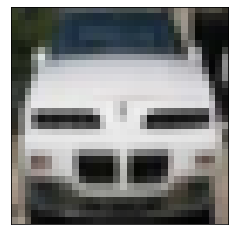

In [33]:
import cv2 as cv
from matplotlib import pyplot as plt

ishape = 128

img = cv.imread('automobile.png')

img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

img = cv.resize(img,(ishape,ishape), interpolation=cv.INTER_NEAREST)# BICUBIC,(36,36,3)->(128,128,3)

plt.imshow(img)

plt.xticks([]), plt.yticks([])

plt.show()

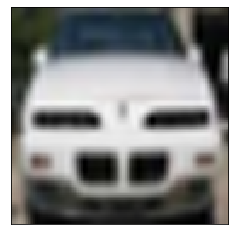

In [34]:
import numpy as np

# Recreate the exact same model, including weights and optimizer.
model = tf.keras.models.load_model('SRCNN.h5')

img = np.reshape(img,(1,ishape,ishape,3)) / 255.

img_SR = model.predict(img)

plt.imshow(img_SR[0])

plt.xticks([]), plt.yticks([])

plt.show()